# Computational Biophysics Homework - Zimm-Bragg model

Tommaso Peviani

**Bibliography**

[1] B. H. Zimm, J. K. Bragg; Theory of the Phase Transition between Helix and Random Coil in Polypeptide Chains. J. Chem. Phys. 1 August 1959; 31 (2): 526–535. https://doi.org/10.1063/1.1730390



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## 1. Melting temperature from theoretical prediction

### 1.a Recap of Zimm-Bragg model

The Zimm-Bragg model [1] describes a polypeptide as linear chain in which each residue can be in two states $h$ (helix) or $c$ (coil). Setting the free energy of $c$ state to zero, we denote the free energy of $h$ state as
$$
f_h = \Delta H - T \Delta S
$$
where $\Delta H$ and $\Delta S$ are the enthalpic and entropic contributions respectively. Since the $c\rightarrow h$ transition correpsonds to the formation of a H-bond, it is physically reasonable to assume 
$$
\begin{align}
\Delta H < 0 \quad & \text{i.e. reduction of energy due to H-bond} \\
\Delta S < 0 \quad & \text{i.e. (small) reduction of configutational entropy} 
\end{align}
$$ 

The associated statistical contribution to the partition function is
$$
s = \exp \{-\beta f_h \} = \exp\{-\Delta H/ k_B T\ + \Delta S / k_B \}
$$
The sign of $f_h$ determines wether the enthalpic term dominates over the entropic one or vice versa:
$$
\begin{align}
f_h < 0 \Leftrightarrow s > 1 & \quad \text{ if } \; |\Delta H| > T|\Delta S| \quad  \text{ i.e. enthalpic term dominant }\\
f_h > 0 \Leftrightarrow s < 1 & \quad \text{ if } \; |\Delta H| < T|\Delta S| \quad \text{ i.e. entropic term dominant }
\end{align}
$$

A further entropic free energy cost is paid whenever a new segment of contiguous $h$ residues appears in the chain
$$
f_{init} = - T \Delta S_{init}
$$
and the associated statistical weight is
$$
\sigma = \exp \{-\beta f_{init} \} =  \exp \{ \Delta S_{init}/ k_B \}
$$
Since the creation of a helix segment implies a large reduction of the chain's configurational entropy, physically relevant values of these quantities are such that
$$ 
\begin{align}
\Delta S_{init} \ll & \Delta S < 0 \\
\Rightarrow \sigma \ll & 1
\end{align}
$$

In the following, we will consider $N, T, \Delta H, \Delta S$ and $\sigma$ (which depends only on $\Delta S_{init}$) as the parameters of the model. It is therefore useful to define the functions `s_function()`in order to parameterize $s$. 

*NOTE*: temperatures are expressed assuming $k_B$ as unit.

In [7]:
def s_function(T,Delta_S,Delta_H):
    return np.exp( - Delta_H / T + Delta_S )

The helicity observable $\theta_N$ is defined as the thermodynamic average of the fraction of residues in the $h$ state, and in the ZB model it can be shown to be a function of $s$, $\sigma$ and the number of residues $N$. This function, which has a rather complex form (ADD REFERENCE), is implemented in the code by `theoretical_zimm_bragg()`.

In [8]:
# function returning theoretical prediction for theta
# copied from hands-on notebook with small adaptations to allow for vectorized computing

def theoretical_ZB(N, s, sigma):
    l_1 = 1 + (s - 1) / 2 + np.sqrt(((s - 1) / 2)**2 + sigma * s)
    l_2 = 1 + (s - 1) / 2 - np.sqrt(((s - 1) / 2)**2 + sigma * s)
    
    r = l_2 / l_1
    
    theta = (l_1 - 1) / (l_1 - l_2)
    # here the *=,/= operators were replaced by explicitly applying *,/ to the previous value of theta
    # in oder to allow for correct broadcasting (used later)
    theta = theta * ( 1 + r**(N + 1) - 2 / N * l_2 / (l_1 - l_2) * (1 - r**N) )    
    theta = theta / ( 1 + (l_1 - 1) / (1 - l_2) * r**(N + 1) )
    
    return theta

In [4]:
# example
theoretical_ZB(10,.6,1.2)

0.3884645153865522

### 1.b Melting curve

The functional dependence of helicity $\theta$ on temperature $T$ for given values of $N, \Delta S, \Delta H, \sigma$ is called melting curve. We use the theoretical expression for $\theta$ to compute it for several values of the model parameters. The implementation relies on vectorization in order to avoid explicit loops.

In [5]:
# each argument is a np.array of values for T, N, Delta_S, Delta_H, sigma
# using broadcasting, all possible combiniations of values for the 5 variables are evaluated in parallel
# returns rank-5 tensor of the values of theta for all combinations 

def compute_melting_curve(Ts, Ns, Delta_Ss, Delta_Hs, sigmas):
    
    # expand axes to rank-5 to allow for broadcasting
    T_grid = Ts[:,np.newaxis,np.newaxis,np.newaxis,np.newaxis] # shape = ( len(T), 1, 1, 1, 1 ) 
    N_grid = Ns[np.newaxis,:,np.newaxis,np.newaxis,np.newaxis]
    Delta_S_grid = Delta_Ss[np.newaxis,np.newaxis,:,np.newaxis,np.newaxis]
    Delta_H_grid = Delta_Hs[np.newaxis,np.newaxis,np.newaxis,:,np.newaxis]
    sigma_grid = sigmas[np.newaxis,np.newaxis,np.newaxis,np.newaxis,:]
    
    # compute in parallel values of s 
    s_grid = s_function(T_grid,Delta_S_grid,Delta_H_grid) # shape(len(T), 1,len(Delta_S), len(Delta_H), 1)

    # compute in parallel values of theta 
    theta_grid = theoretical_ZB(N_grid,s_grid,sigma_grid) # shape(len(T), len(N), len(Delta_S), len(Delta_H), len(sigma))
    return(theta_grid)


In [6]:
# compute melting curves for plotting

Ts = np.arange(.1,2,.01)
Ns = np.logspace(1,4,10).astype(int)
Delta_Ss = np.linspace(-2,-.5,10)
Delta_Hs = np.linspace(-2,-.5,10)
sigmas = np.logspace(-4,-1,10)

melting_curves= compute_melting_curve(Ts,Ns,Delta_Ss,Delta_Hs,sigmas)

print('output shape: ', melting_curves.shape)

output shape:  (190, 10, 10, 10, 10)


In [7]:
# plot melting curves for different values of one variable, keeping others fixed

def plot_melting_curves(var, idx=[':',0,0,0]):
    # ARGUMENTS:
    # var = [Ns, Delta_Ss, Delta_Hs, sigmas] list of vectors of variable values
    # idx = [idx_N, idx_Delta_S, idx_Delta_H, idx_sigma] list of indices chosen for each vector
    # idx equal to ':' associated to vector whose index is looped over

    # INDICES
    # k: index of a vector in var[] list 
    # i: index of a value in var[k] vector
    
    k_loop = idx.index(':')

    strings = ['$N=$', '$\\Delta S =$', '$\\Delta H = $', '$\\sigma = $']
    formats = ['d','.1f','.1f','.5f']

    title_str = 'Melting curves:'
    for k in range(len(var)):
        if k != k_loop:  
            title_str += ' ' + strings[k] + format( var[k][idx[k]], formats[k] )
    
    plt.title( title_str  )
    plt.xlabel('$T$')
    plt.ylabel('$\\theta$')
    plt.grid(True,alpha=.3)

    # plotting for all values in var[k_loop] vector
    for i in range(len(var[k_loop])):
        idx[k_loop] = i
        lab = strings[k_loop] + format(var[k_loop][i], formats[k_loop])
        plt.plot(Ts, melting_curves[:,idx[0],idx[1],idx[2],idx[3]],label=lab )

    plt.legend()
    plt.show()
  

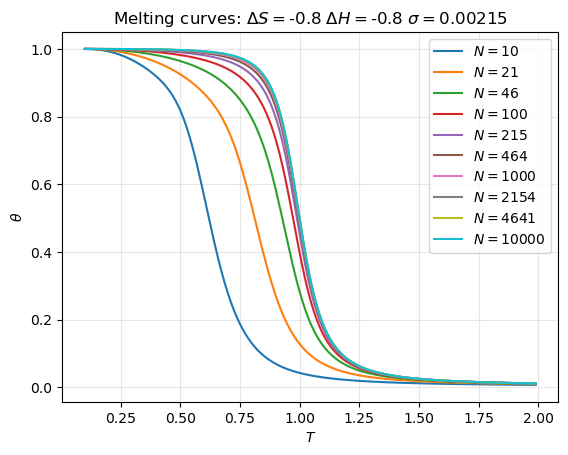

In [8]:
var = [Ns,Delta_Ss,Delta_Hs,sigmas]

# for instance here if we want to loop over Ns, 
# keeping other variables fixed at values Delta_Ss[7], Delta_Hs[7], sigmas[4]
# we can set:
idx = [':',7,7,4] 

#  Melting curves for different N
plot_melting_curves(var, idx)

As we can see from the plot, $\theta$ is a monotonic, sigmoid-like decreasing function of $T$. In fact, as temperature grows, the enthalpic contribution to 
$$
s = \exp \{-\beta f_h \} = \exp\{-\Delta H/ k_B T\ + \Delta S / k_B \}
$$
becomes negligible and, since $\Delta S<1$, $s$ becomes $<1$. This in turn implies that $h$ states for the residues become statiscally discouraged in favour of $c$ states.

**Melting curves varying $N$.** 
We can observe that, as $N$ grows, the melting curve becomes more shifted towards right, i.e. $\theta$ at a given $T$ increases with $N$. The physical reason is that, the more the residues are, the easier is for them to distribute the entropic cost $\Delta S_{init}$ of forming new helix segments: this in turn favours the $h$ state. Moreover, as the system size grows, the melting curve becomes steeper and more similar to a step function (suggesting that in the $N\rightarrow \infty$ limit a proper phase transition should happen). Notice that as $N$ grows, the temperatures at which $\theta$ decreases significantly (more precisely, the melting temperature $T_M$ defined later) appear to have an upper bound instead of diverging (i.e. the transition exists at finite temperature in the $N\rightarrow\infty$ limit). 

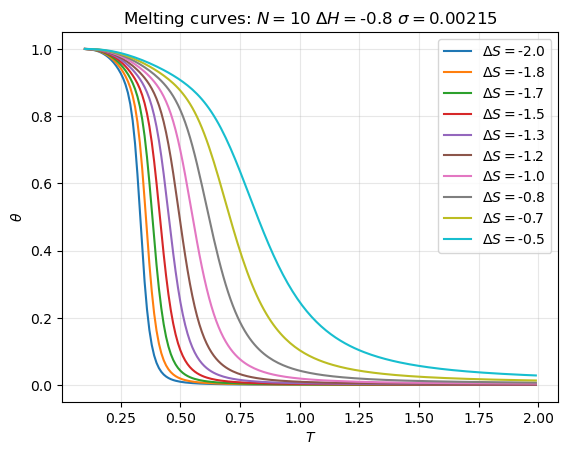

In [9]:
#  Melting curves for different Delta_S
plot_melting_curves(var, [0,':',7,4])

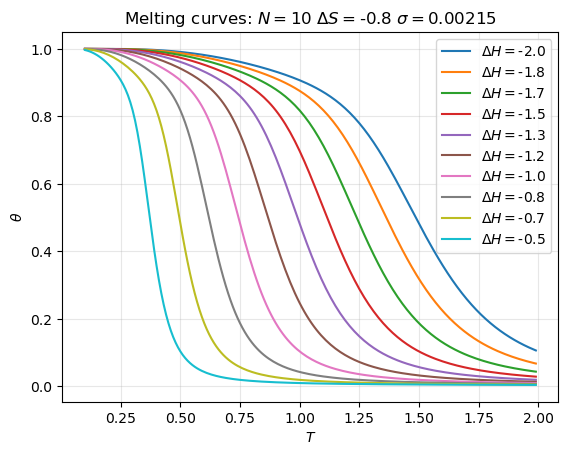

In [10]:
#  Melting curves for different Delta_H
plot_melting_curves(var, [0,7,':',4])

**Melting curves varying $\Delta S$, $\Delta H$.** 
As can be easily argued from the expression of $s$ in terms of $\Delta S$ and $\Delta H$, the effects of changing these two competing variables are opposite. 
$$
\begin{align}
\Delta S_1 < \Delta S_2 <0  \quad & \Rightarrow \quad \theta(T|\Delta S_1) < \theta(T|\Delta S_2) \\
\Delta H_1 < \Delta H_2 <0 \quad & \Rightarrow \quad  \theta(T|\Delta H_1) > \theta(T|\Delta H_2) 
\end{align}
$$
Physically a larger (in absolute value) entropy loss $\Delta S$ for $c \rightarrow h$ flips makes $h$ states less likely, resulting in a lower value for $\theta$, while a larger (again in absolute value) reduction in enthalpy has the opposite effect.

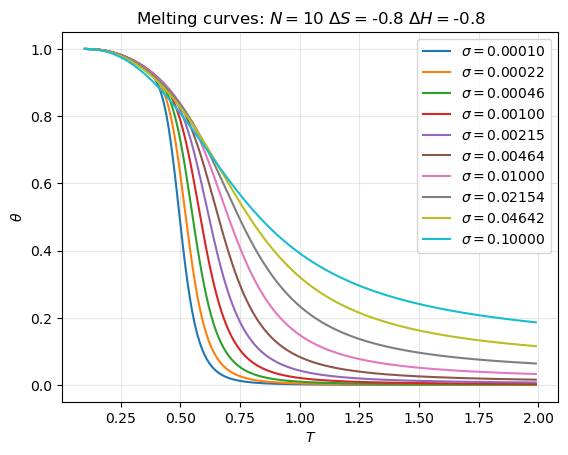

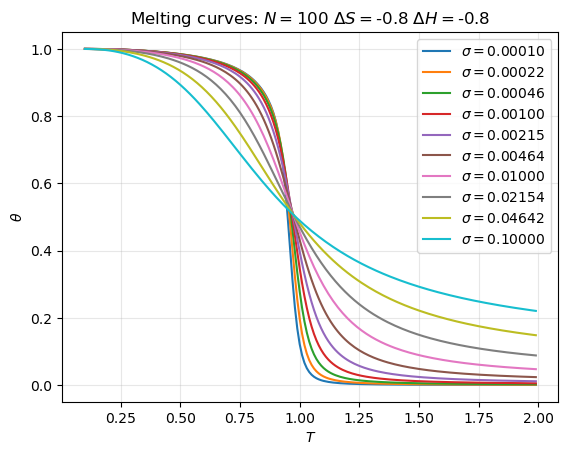

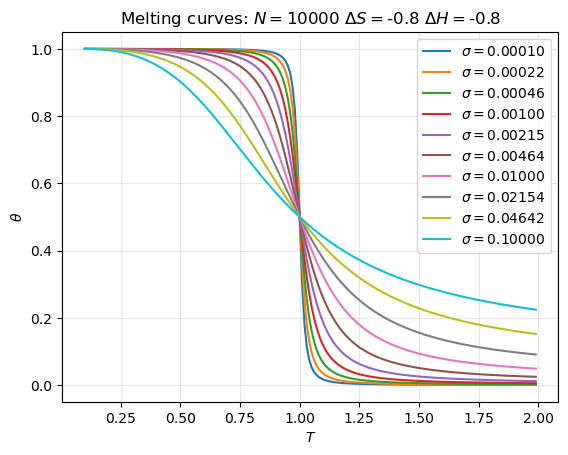

In [11]:
#  Melting curves for different Delta_S
plot_melting_curves(var, [0,7,7,':'])
plot_melting_curves(var, [3,7,7,':'])
plot_melting_curves(var, [9,7,7,':'])

**Melting curves varying $\sigma$.**
To interpret the dependence of the melting curve on $\sigma$, recall that $\Delta S_{init}<0$ is the entropy loss of forming a new segment of adjacent $h$ residues, and $\sigma = \exp ( \Delta S_{init} / k_B ) < 1$ is the corresponding statitical weight.
Then, increasing (in absolute value) the entropy loss $\Delta S_{init}$, $\sigma$ decreases. For smaller $\sigma$ values, we can observe in the plot that the sigmoid $\theta(T$ becomes steeper, more similar to a step-function.

Physically, one can understand this in the limit where $N \gg 1$ and $\Delta S_{init} \ll 0$. In this limit, cooperativity is the dominant factor of the system, and therefore all residues tend to be in the same state in order to minimize the huge entropic price paid for having many segments of residues in $h$. At high temperature all residues are in $c$ state, since single-residue entropy $T\Delta S$ dominates over enthalpy $\Delta H$. Let us now gradually decrease temperature: at a certain point, $T$ becomes low enough for enthalphy $\Delta H$ to win over single-residue entropy $T\Delta S$; then if $T$ further decreases, the enthalpic gain of flipping  all residues together from $c$ to $h$ state will be enough to compensate the large entropic price $\Delta S_{init}$, that is paid only once. For large $N$ (see 3rd plot $N=10000$), the temperature at which the collective flipping happens ($T_M$) depends mostly on $\Delta S$ and $\Delta H$, while $\sigma$ has predominantly a role in determining the sharpness of the transition, as can be seen from the plot. 
However, as $N$ decreases (1st plot $N=10$) and less residues can cooperate to pay $\Delta S_{init}$, the dependence of $T_M$ on $\sigma$ becomes more evident.

### 1.c Melting temperature

The melting temperature $T_M$ is defined as the temperature at which, on thermodynamic average, half of the residues are in the $h$ state, i.e.
$$
\theta_N (T_M) = \frac{1}{2}
$$
A possible method to compute $T_M$ - as suggested in the assignment - is the following.
Given a set of temperaures $\{T_1,...,T_n \}$ s.t. $ T_{i+1} = T_i + \Delta T $ we compute, with the method implemented above, the values $\{\theta(T_1), ..., \theta(T_n)\} \equiv \{\theta_1,...,\theta_n\}$, reconstructing the melting curve. The set of temperatures must be such that:

* $T_1 < T_M < T_n \quad$ i.e. the melting temperature must fall inside the sampled interval;
    
* $\Delta T \;$ small enough to allow for good interpolation of the melting curve.

Then, since $\theta(T)$ is monotonic, it is possible to interpolate its inverse function $\hat{T}(\theta)$ using the `interp1d()` class from the `scipy.interpolate` module, and obtain the melting temperature by evaluating it at $\theta = 0.5$:
$$
T_M = \hat{T}(\theta=0.5)
$$

In [12]:
from scipy.interpolate import interp1d

In [13]:
# function that inteprpolates melting temperatures
# ARGUMENTS: melting_curves[] tensor
#           Ts[] array
def calc_melting_temp( melting_curves, Ts):

    # interoplate functions
    theta_interp = interp1d(Ts, melting_curves, axis=0)
    # evaluate melting temperaures
    melting_temp = theta_interp(.5)

    return melting_temp

In [14]:
# example: use previously computed melting curves

print('melting_curves:', melting_curves.shape)
melting_temp = calc_melting_temp(melting_curves,Ts)
print('melting_temp:',melting_temp.shape)

melting_curves: (190, 10, 10, 10, 10)
melting_temp: (10, 10, 10, 10)


For the actual analysis of the melting temperature's dependence on $N, \Delta S, \Delta H, \sigma$, we need to compute the melting curves $\theta(T)$ for more values of these parameters than we have done up to now. For instance, a sufficiently smooth plot of $T_M$ as a function of $N$ is obtained with at least $n_{N}=50$ values of $N$, and the same is true for the other 3 parameters. In principle, the function `compute_melting_curve()` allows to compute $n_{N}\times n_{\Delta S} \times n_{\Delta H} \times n_{\sigma}$ melting curves all at once. Anyway, if we naively set $ n_{N} = n_{\Delta S} = n_{\Delta H} = n_{\sigma} \equiv n $, the computation is $\mathcal{O}(n^4)$ and becomes unfeasible on a laptop for $n \gtrsim 20$. There is anyway no need to make all the parameters vary simultaneously. In fact, the goal heare is to produce plots of $T_M$ vs one or at most two parameter, and therefore we can keep all the others fixed at some intermediate, phisically reasonable value.

In [15]:
# function for 1D plotting of melting temperature vs one variable

def plot_melting_temp(melting_temp, var, idx=['x',0,0,0], k_label=None):
    # ARGUMENTS:
    # melting_temp = tensor of all melting temperatures
    # var = [Ns, Delta_Ss, Delta_Hs, sigmas] list of vectors of variable values
    # idx = [idx_N, idx_Delta_S, idx_Delta_H, idx_sigma] list of indices chosen for each vector
    # idx equal to 'x' associated to variable vs which melting temp is plotted
    
    # INDICES
    # k: index of axis in melting_temp[] tensor <-> vector in var[] list 
    # i: index of value in var[k] vector
    
    k_xaxis = idx.index('x') # index of variable plotted on x axis
  
    strings = ['$N$', '$\\Delta S $', '$\\Delta H $', '$\\sigma $']
    formats = ['d','.1f','.1f','.4f']
    xscales = ['log', 'linear', 'linear', 'log' ]

    slices = [] # list of index slice() objects for each axis of melting_temp[]
    title_str = 'Melting temperature vs '+ strings[k_xaxis] +':'
    for k in range(len(var)):
        if k == k_xaxis:
            slices.append( slice(None) )
        else:
            slices.append( idx[k] )
            if k != k_label:
                title_str += ' ' + strings[k] + '=' + format( var[k][idx[k]], formats[k] )
    
    slices = tuple(slices)
    
    plt.title( title_str  )
    plt.xlabel(strings[k_xaxis])
    plt.ylabel('$T_M$')
    plt.grid(True,alpha=.3)
    plt.xscale(xscales[k_xaxis])

    label = None
    if k_label != None:
        label = strings[k_label] + '=' + format( var[k_label][idx[k_label]], formats[k_label] )
        #label = 'Pino Scotto'
    plt.plot(var[k_xaxis], melting_temp[slices],alpha=.5, label=label)
    plt.scatter(var[k_xaxis], melting_temp[slices],s=5)
    plt.legend()
    
    

In [16]:
# Plotting melting temperature vs 2 variables

import plotly.graph_objects as go

def plot_melting_temp2D(melting_temp, var, idx=['y','x',0,0]):
    # ARGUMENTS:
    # melting_temp = tensor of all melting temperatures
    # var = [Ns, Delta_Ss, Delta_Hs, sigmas] list of vectors of variable values
    # idx = [idx_N, idx_Delta_S, idx_Delta_H, idx_sigma] list of indices chosen for each vector
    # idx equal to 'x','y' associated to variables vs which melting temp is plotted
    # LIMITATION: 'y' must be placed before 'x' in idx[] list, in order to get correct plot   

    # INDICES
    # k: index of axis in melting_temp[] tensor <-> vector in var[] list 
    # i: index of value in var[k] vector
    
    k_xaxis = idx.index('x') # index of variable plotted on x axis
    k_yaxis = idx.index('y') # index of variable plotted on y axis

    #strings = ['$N$', '$\\Delta S $', '$\\Delta H $', '$\\sigma $']
    strings = ['N','ΔS','ΔH','σ']
    formats = ['d','.1f','.1f','.4f']
    xscales = ['log', 'linear', 'linear', 'log' ] # used for both x and y axis

    slices = [] # list of index slice() objects for each axis of melting_temp[]
    title_str = 'Melting temperature vs '+ strings[k_xaxis] + ',' + strings[k_yaxis] + ':'
    for k in range(len(var)):
        if(k == k_xaxis or k == k_yaxis):
            slices.append( slice(None) )
        else:
            slices.append( idx[k] )
            title_str += ' ' + strings[k] + '=' + format( var[k][idx[k]], formats[k] )
    
    slices = tuple(slices)
    
    
    # 2D Colormap 
    plot = plt.pcolormesh(var[k_xaxis], var[k_yaxis], melting_temp[slices], cmap='plasma', shading='gouraud')
    cbar = plt.colorbar(plot)
    cbar.set_label('$T_M$', rotation=0)
    plt.title(title_str)
    plt.xlabel(strings[k_xaxis])
    plt.ylabel(strings[k_yaxis])
    plt.xscale(xscales[k_xaxis])
    plt.yscale(xscales[k_yaxis])
    plt.show()
    

    # 3D Surface plot
    fig = go.Figure(data=[go.Surface(
                    z=melting_temp[slices], x=var[k_xaxis], y=var[k_yaxis],
                    colorscale='plasma',
                    colorbar=dict(title='T_M')
                    )])
    fig.update_layout(
                    title = dict(text=title_str), 
                    scene=dict(
                        xaxis= dict( title=strings[k_xaxis], type=xscales[k_xaxis] ), 
                        yaxis= dict( title=strings[k_yaxis], type=xscales[k_yaxis] ),
                        zaxis_title='T_M'
                    ),
                    autosize=False,
                    width=500, height=500,
                    margin=dict(l=65, r=50, b=65, t=90) )
    fig.show()
    


**$T_M$ vs $N$**

melting_curves: (290, 100, 1, 1, 7)
melting_temp: (100, 1, 1, 7)


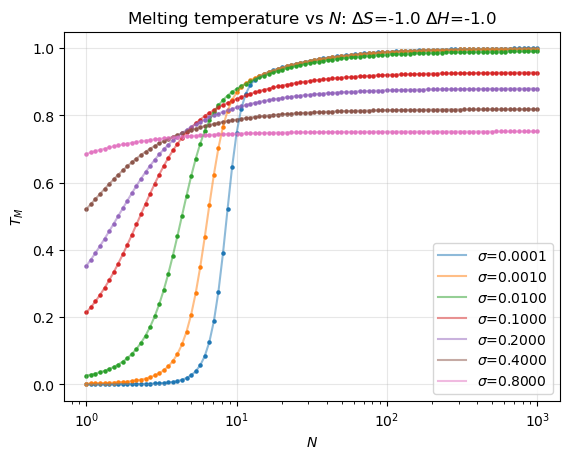

In [17]:
# Melting temp vs N

# compute melting curves for interpolating T(theta)
Ts = np.arange(.1,3,.01)
Ns = np.logspace(0,3,100)#.astype(int) # 100 values of N

Delta_Ss = np.array([-1]) # fixed at one value
Delta_Hs = np.array([-1]) # fixed at one value
sigmas = np.concatenate( [ np.logspace(-4,-1,4), .1* 2**np.arange(1,4) ], axis=0)  # 5 orders of magnitude for sigma

melting_curves= compute_melting_curve(Ts,Ns,Delta_Ss,Delta_Hs,sigmas)
#np.save('melting_curves.npy',melting_curves)

# compute melting temp
print('melting_curves:', melting_curves.shape)
melting_temp = calc_melting_temp(melting_curves,Ts)
print('melting_temp:',melting_temp.shape)

# plot melting temperature vs N
var = [Ns, Delta_Ss, Delta_Hs, sigmas]
for i in range(len(sigmas)):
    plot_melting_temp(melting_temp,var,idx=['x',0,0,i],k_label=3)

Let us comment the melting temperature's dependence on $N$. In the limit case of $\Delta S_{init}=0 \Leftrightarrow \sigma = 1 $, in which there is no cooperativity, we expect $T_M$ to be independent of $N$. In fact, as one can see in the plots, as $\sigma$ gets closer to $1$, the curve $T_M(N)$ becomes more flat. For values  $\Delta S_{init} < 0 \Leftrightarrow \sigma < 1 $, the residues cooperate to pay the initialization cost: the more they are, the easier is to form helices, and therefore $T_M$ is an increasing function of $N$. As $\sigma$ approaches zero, $T_M(N)$ tends to a step-like function, and the step position on the $N$ axis shifts towards the right: in fact, the larger the entropic loss $|\Delta S_{init}|$, the more residues are required to cooperate to form an helix.

**$T_M$ vs $\sigma$**

melting_curves: (290, 8, 1, 1, 100)
melting_temp: (8, 1, 1, 100)


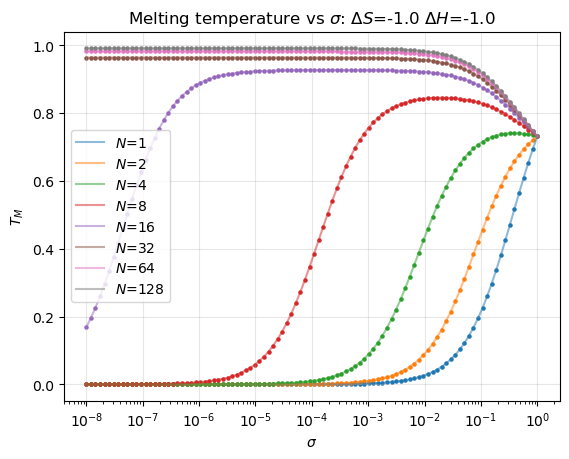

In [18]:
# Melting temp vs N

# compute melting curves for interpolating T(theta)
Ts = np.arange(.1,3,.01)
Ns = 2**np.arange(0,8).astype(int) # 8 values for N

Delta_Ss = np.array([-1]) # fixed at one value
Delta_Hs = np.array([-1]) # fixed at one value
sigmas = np.logspace(-8,0,100) # 100 values for sigma

melting_curves= compute_melting_curve(Ts,Ns,Delta_Ss,Delta_Hs,sigmas)
#np.save('melting_curves.npy',melting_curves)

# compute melting temp
print('melting_curves:', melting_curves.shape)
melting_temp = calc_melting_temp(melting_curves,Ts)
print('melting_temp:',melting_temp.shape)

# plot melting temperature vs sigma
var = [Ns, Delta_Ss, Delta_Hs, sigmas]
for i in range(len(Ns)):
    plot_melting_temp(melting_temp,var,idx=[i,0,0,'x'],k_label=0)

Let us consider now the melting temperature as a function $\sigma$. As anticipated above, for $\Delta S_{init} = 0$, i.e. $\sigma = 1$ (right of the plot) , the value of $T_M$ is the same for all $N$, and is fixed by $\Delta S$ and $\Delta H$ (see later). As $\sigma$ starts to decrease, the number $N$ becomes relevant in determining $T_M$. Take the limiting case of $N=1$ (though we discussed that the ZB model for proteins makes sense only for $N>4$): in this case, the cost $\Delta S_{init}<0$ must be paid by a single residue, so the melting temperature decreases monotonically as $\sigma$ decreases. What happens instead for a large $N$? Initially, decreasing $\sigma$ from 1 forces the residues to collaborate to initialize helices, incentivating the formation of fewer but larger segments of consecutive $h$ with respect to the $\sigma=1$ case: therefore, the total fraction of residues in $h$ grows. This explains why, for large $N$, $T_M(\sigma)$ grows as we move left from $\sigma =1$. Anyway, at a certain point, $\sigma$ will become so small that the residues will not be enough to pay the shared price $|\Delta S_{init}|$. Thus, as $\sigma \rightarrow 0^+$ we always have $T_M \rightarrow 0$.

**$T_M$ vs $N,\sigma$**

melting_curves: (790, 100, 1, 1, 100)
melting_temp: (100, 1, 1, 100)


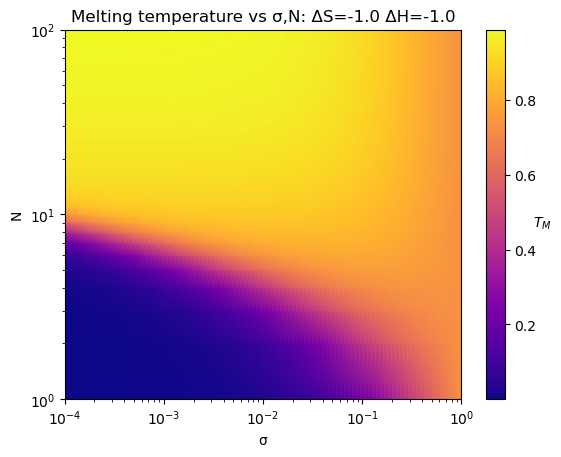

In [19]:
# Melting temp vs N and sigma

# compute melting curves for interpolating T(theta)
Ts = np.arange(.1,8,.01)
Ns = np.linspace(1,100,100)#.astype(int) # 100 values for N
Delta_Ss = np.array([-1]) # fixed at one value
Delta_Hs = np.array([-1]) # fixed at one value
sigmas = np.logspace(-4,0,100) # 100 values for sigma

melting_curves = compute_melting_curve(Ts,Ns,Delta_Ss,Delta_Hs,sigmas)
#np.save('melting_curves.npy',melting_curves)

# compute melting temp
print('melting_curves:', melting_curves.shape)
melting_temp = calc_melting_temp(melting_curves,Ts)
print('melting_temp:',melting_temp.shape)

# plot
var = [Ns, Delta_Ss, Delta_Hs, sigmas]
plot_melting_temp2D(melting_temp,var,idx=['y',0,0,'x'])

We can now see the interplay of $N$ and $\sigma$ in the determining the melting temperature, by plotting $T_M$ against both variables at once. The plots $T_M(N,\sigma)$ are presented as color maps and surface plots. These plots provide a good visualization of the previously discussed fact that, as $\sigma$ decreases from the value of $1$, the dependence of $T_M$ on $N$ becomes stronger.

**$T_M$ vs $\Delta S$ and $\Delta H$** 

The model parameters $\Delta S$ and $\Delta H$ represent respectively the entropic and enthalpic variations associated to a single residue for a $c\rightarrow h$ flip . As mentioned before, physical considerations restrict us to consider values $\Delta S < 0$, $\Delta H < 0$, and the free energy variation corresponding to the $c \rightarrow h$ flip is
$$
f_h = \Delta H - T \Delta S
$$
Therefore, it is interesting to study the competition of these two terms in determining the melting curve.

As can be seen from the plots below:
* T_M increases monotonically with $\Delta S$. Indeed, the absolute value $|\Delta S|$ is the reduction in entropy due to $c\rightarrow h$, and the smaller its value is, the easier is for $h$ states to form;
* T_M decreases monotonically with $\Delta H$. In fact, $|\Delta H|$ is the reduction in free energy due to $c\rightarrow h$: and the larger it is, the more advantageous is for a residue to be in $h$ state.

Since both terms appear in the partition function through the factor
$$
s = \exp \{-\beta f_h \} = \exp\{-\Delta H/ k_B T\ + \Delta S / k_B \}
$$
it is reasonable to expect for the dependence of $T_M$ on $\Delta S$ and $\Delta H$ to be the approximately the same (not identical, since only one term appears in $s$ as divided by $T$) apart from an inversion of the $x$-axix. This is confirmed from the plots, where $T_M(\Delta S)$ and $T_M(\Delta H)$ are respectively an increasing and a decreasing sigmoid. 

Finally, we can consider the 2-d plots of $T_M(\Delta S, \Delta H)$ to visualize the competition of the two variables. As can be seen from the plots. in the $(\Delta S, \Delta H)$ plane there are a direction of minimal and a direction of maximal variation of $T_M$. If the factor $1/T$  multiplying $\Delta H$ in $s$ had been a constant, with $T=T^*$, these directions would be:
* $T^*\Delta S - \Delta H = const \quad\Rightarrow$ maximal variation of $T_M$;
* $T^*\Delta S + \Delta H = const \quad\Rightarrow$ $T_M=const$.

Since there is the factor $1/T$, these two directions appear to be slightly rotated.

melting_curves: (290, 7, 300, 1, 1)
melting_temp: (7, 300, 1, 1)


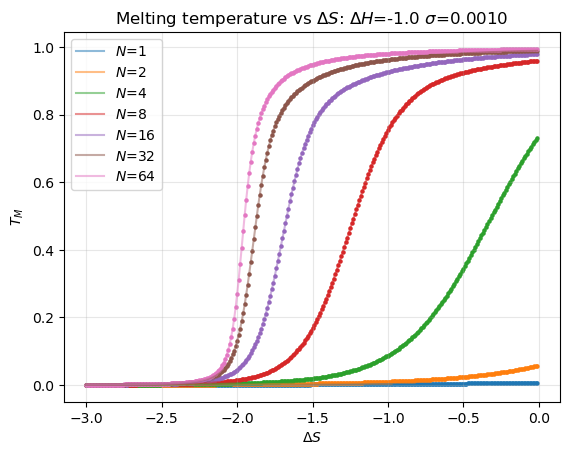

In [33]:
# Melting temp vs Delta_S

# compute melting curves for interpolating T(theta)
Ts = np.arange(.1,3,.01)
Ns = 2**np.arange(0,7).astype(int)
Delta_Ss = np.arange(-3,0,.01) 
Delta_Hs = np.array([-1]) # fixed at one value
sigmas = np.array([1e-3])

melting_curves= compute_melting_curve(Ts,Ns,Delta_Ss,Delta_Hs,sigmas)
#np.save('melting_curves.npy',melting_curves)

# compute melting temp
print('melting_curves:', melting_curves.shape)
melting_temp = calc_melting_temp(melting_curves,Ts)
print('melting_temp:',melting_temp.shape)

# plot melting temperature vs sigma
var = [Ns, Delta_Ss, Delta_Hs, sigmas]
for i in range(len(Ns)):
    plot_melting_temp(melting_temp,var,idx=[i,'x',0,0],k_label=0)

melting_curves: (290, 7, 1, 300, 1)
melting_temp: (7, 1, 300, 1)


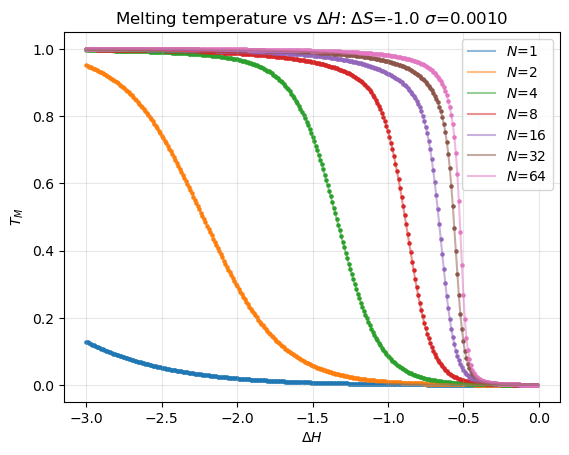

In [34]:
# Melting temp vs Delta_H

# compute melting curves for interpolating T(theta)
Ts = np.arange(.1,3,.01)
Ns = 2**np.arange(0,7).astype(int)
Delta_Ss = np.array([-1]) # fixed at one value
Delta_Hs = np.arange(-3,0,.01) 
sigmas = np.array([1e-3])

melting_curves= compute_melting_curve(Ts,Ns,Delta_Ss,Delta_Hs,sigmas)
#np.save('melting_curves.npy',melting_curves)

# compute melting temp
print('melting_curves:', melting_curves.shape)
melting_temp = calc_melting_temp(melting_curves,Ts)
print('melting_temp:',melting_temp.shape)

# plot melting temperature vs sigma
var = [Ns, Delta_Ss, Delta_Hs, sigmas]
for i in range(len(Ns)):
    plot_melting_temp(melting_temp,var,idx=[i,0,'x',0],k_label=0)

melting_curves: (390, 1, 300, 300, 1)
melting_temp: (1, 300, 300, 1)


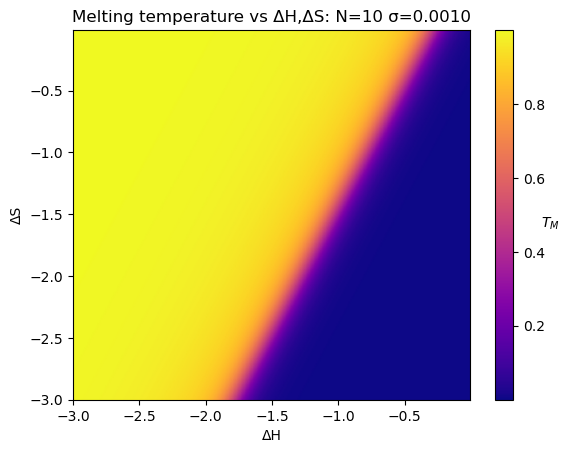

In [23]:
# Melting temp vs Delta_S and Delta_H

# compute melting curves for interpolating T(theta)
Ts = np.arange(.1,4,.01)
Ns = np.array([10]) # 100 values for N
Delta_Ss = np.arange(-3,0,.01)
Delta_Hs = np.arange(-3,0,.01)
sigmas = np.array([1e-3]) 

melting_curves = compute_melting_curve(Ts,Ns,Delta_Ss,Delta_Hs,sigmas)
#np.save('melting_curves.npy',melting_curves)

# compute melting temp
print('melting_curves:', melting_curves.shape)
melting_temp = calc_melting_temp(melting_curves,Ts)
print('melting_temp:',melting_temp.shape)

# plot
var = [Ns, Delta_Ss, Delta_Hs, sigmas]
plot_melting_temp2D(melting_temp,var,idx=[0,'y','x',0])

### 1.d Extra: reproducing Figure 4 from the Zimm-Bragg article 

(2, 2, 100)


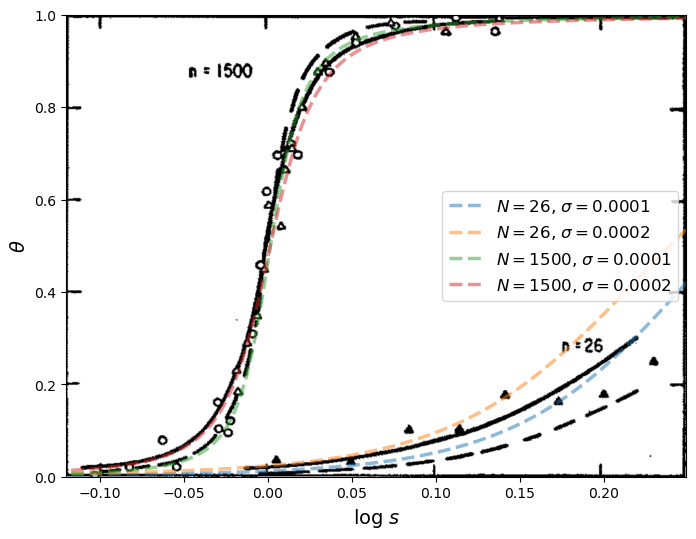

In [66]:
import matplotlib.image as img 
from PIL import Image

Ns = [26,1500]
sigmas = [1e-4,2*1e-4]
#ss = np.logspace(-.15,.25,100)
lnss = np.linspace(-.15,.25,100)
ss = np.exp( lnss )
thetas = []
for N in Ns:
    l = []
    for sigma in sigmas:
        l.append( theoretical_ZB(N,ss,sigma) )
    thetas.append(l)

thetas = np.array(thetas)
print(thetas.shape)


path = '/Users/tommaso/Library/Mobile Documents/com~apple~CloudDocs/Documents/Fisica_Magistrale/CompBioPhys/Homework1-ZimmBragg/'
path += 'Fig4_ZimmBragg.png'


# Load the image

plt.figure(figsize=[8,6])
image = Image.open(path)
plt.xlim([-.120,.249])
plt.ylim([0,1])
plt.imshow(image, extent=[-.120,.249,0,1],aspect='auto') 


for i in range(len(Ns)):
    for j in range(len(sigmas)):
        label = '$N=$' + format(Ns[i]) + ', $\\sigma=$' + format(sigmas[j],'.4f')
        plt.plot(lnss,thetas[i,j,:],linestyle='--',linewidth=2.5,alpha=.5, label=label)

plt.xlabel('log $s$', fontsize=14)
plt.ylabel('$\\theta$', fontsize=14)
plt.legend(loc='right', fontsize=12)
plt.show()




## 2. Monte Carlo simulations

In [21]:
'''
Function that randomly initializes
1. chain[] vector of residue states (0,1)=(coil or helix)
2. res_type[] vector of AA type (0,...,n_res_types)
adapted from hands-on notebook
'''
def initialize_chain(N=10,n_res_types=1):

    # vector containing the state of each residue, either coil (0) or helix (1)
    chain = np.random.choice([0, 1], size=N)
    # vector containing the AA type for each residue
    res_type = np.random.choice( np.arange(n_res_types), size=N )

    return chain, res_type

In [22]:
# examples
chain, res_type = initialize_chain()
print('Chain of N =', np.size(chain), ' residues of same type:' )
print('state = ',chain)
print('AA type = ', res_type)

n_res_types = 4
chain2, res_type2 = initialize_chain(10,n_res_types)
print('\nChain of N =', np.size(chain2), ' residues of ', n_res_types ,' different types:' )
print('state = ',chain2)
print('AA type = ', res_type2)

Chain of N = 10  residues of same type:
state =  [1 1 0 1 0 0 0 1 1 0]
AA type =  [0 0 0 0 0 0 0 0 0 0]

Chain of N = 10  residues of  4  different types:
state =  [1 1 1 1 1 0 1 0 0 0]
AA type =  [3 3 1 0 3 1 2 2 1 1]


In [23]:
'''
Returns the ratio between the statistical weights due to the flipping of the index-th residue.
Arguments:
    index: residue index
    chain: vector of residue states
    res_type: vector of residue types
    ss: vector of values of h-bond term s for different residue types
    sigma: cooperative term
Taken from hands-on notebook and adapted to manage different AA types
'''

def change_probability(index, chain, res_type, ss, sigma):
    current_state = chain[index]
    new_state = 1 - current_state

    # h-bond term: adapted to different AA types
    s = ss[ res_type[index] ] # s value depends on AA type
    if new_state == 0:
        prob = 1 / s
    else:
        prob = s
    
    # cooperative (initiation) term
    if index == 0: # first residue
        if chain[index + 1] == 0:
            if new_state == 1:
                prob *= sigma
            else:
                prob /= sigma
    elif index == N - 1: # last residue
        if chain[index - 1] == 0:
            if new_state == 1:
                prob *= sigma
            else:
                prob /= sigma
    # here we take into account two cases: either a helix is split in two or a helix is created
    # in both cases we pay the cooperative price
    elif new_state != chain[index - 1] and new_state != chain[index + 1]:
        prob *= sigma
    # here we take into account the case where the flipped residue either removes an helix, or join two helices
    elif new_state == chain[index - 1] and chain[index - 1] == chain[index + 1]:
        prob /= sigma
    
    return prob
  

In [24]:
# example

sigma = 1e-3


print('Chain with identical AA:\n')
# generate randomly a value of s in interval [1,2]
ss = 1 + np.random.rand(1)
print('s = ', ss)
print('\nCurrent chain state: ', chain, '\n')
# calculate change probability for different residues
for i in range(np.size(chain)):
    p = change_probability(i,chain,res_type,ss,sigma)
    print('Residue ', i, ' type ', res_type[i], ' change probability = ', p)


print('\n\nChain with different AA:\n')
# generate randomly n_res_types values of s in interval [1,2]
ss = 1 + np.random.rand(n_res_types) 
print('s values for different AA: ', ss)
print('\nCurrent chain state: ', chain2, '\n')
# calculate change probability for different residues
for i in range(np.size(chain2)):
    p = change_probability(i,chain2,res_type2,ss,sigma)
    print('Residue ', i, ' type ', res_type2[i], ' change probability = ', p)


Chain with identical AA:

s =  [1.56832718]

Current chain state:  [1 1 0 1 0 0 0 1 1 0] 

Residue  0  type  0  change probability =  0.6376220541603388


NameError: name 'N' is not defined

Looking at change probability for the different residues, we see that for typical $\sigma \ll 1$ values, flips that reduce the total number of streaks of consecutive $h$ states are strongly encouraged, while flips that increase that number are disfavoured

In [ ]:
'''
Performs a single MC step, consistimg of N proposed flips accepted/refused according to Metropolis algo.
Adapted from hands-on notebook.
'''

def MC_step(chain,res_type,ss,sigma):
    # MC step = N proposed moves 
    N = np.size(chain)
    for _ in range(N):
        
        # randomly pick a residue to flip
        index = np.random.randint(N)
    
        # calculate the probability change
        prob = change_probability(index,chain,res_type,ss,sigma)
    
        # Metropolis algo: accept or reject the change 
        if prob > 1 or np.random.rand() < prob:
            chain[index] = 1 - chain[index]
        

In [ ]:
# example
ss = 1 + np.random.rand(1)
print('state before MC step: ',chain)
MC_step(chain,res_type,ss,sigma)
print('state after MC step: ',chain)


In [ ]:
'''
Runs MC simulation. Arguments
    n_steps
'''
def MC_sim(n_steps,n_calc)